# Build an ARMA Predictive Time Series Model for Asheville Larcenies
 _this is a work in progress and needs further elaboration to be solid_

we will get a few runtime warnings when loading libraries -- 
supressing all warnings is generally not a good idea

# Setup

In [1]:
import warnings as warn
warn.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
import seaborn as sns

In [3]:
%matplotlib inline

set figure size

In [4]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

set seaborn style

In [5]:
sns.set_style("white")
# sns.set_context("poster")

# Load the data

In [6]:
# s is our raw series of observations
s = pd.read_pickle('lar_series.pkl')

In [7]:
X = s.resample('M').count()

In [8]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: offense_short_description, dtype: float64

In [9]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

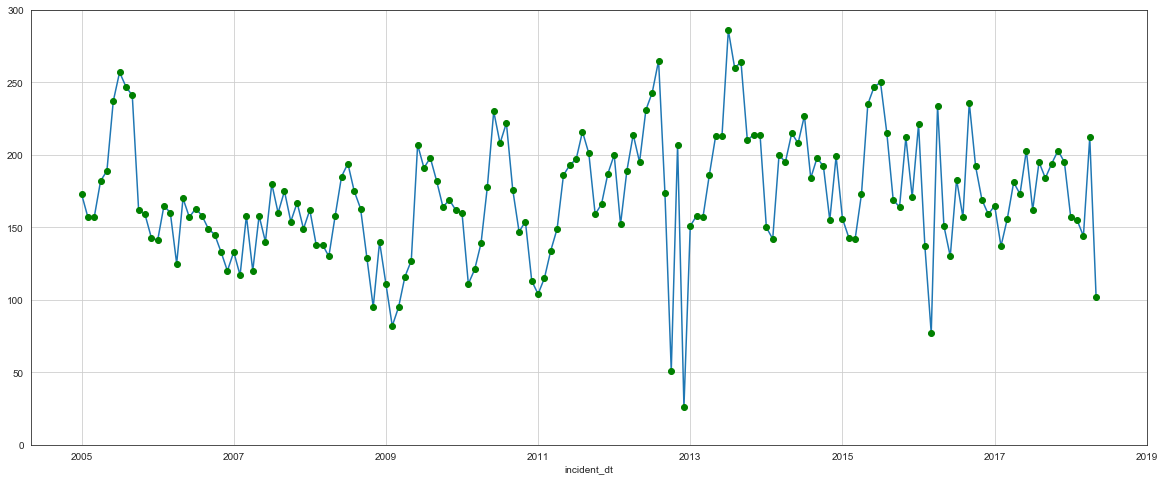

In [10]:
plt.ylim(0, 300)
X.plot()
X.plot(style='go', grid=True)

In [11]:
s_model = seasonal_decompose(X, model='additive')

In [13]:
res = s_model.seasonal.to_frame()
res.columns = ['seasonal']
res['trend'] = s_model.trend
res['pred'] = res['trend'] + res['seasonal']
res['actual'] = X

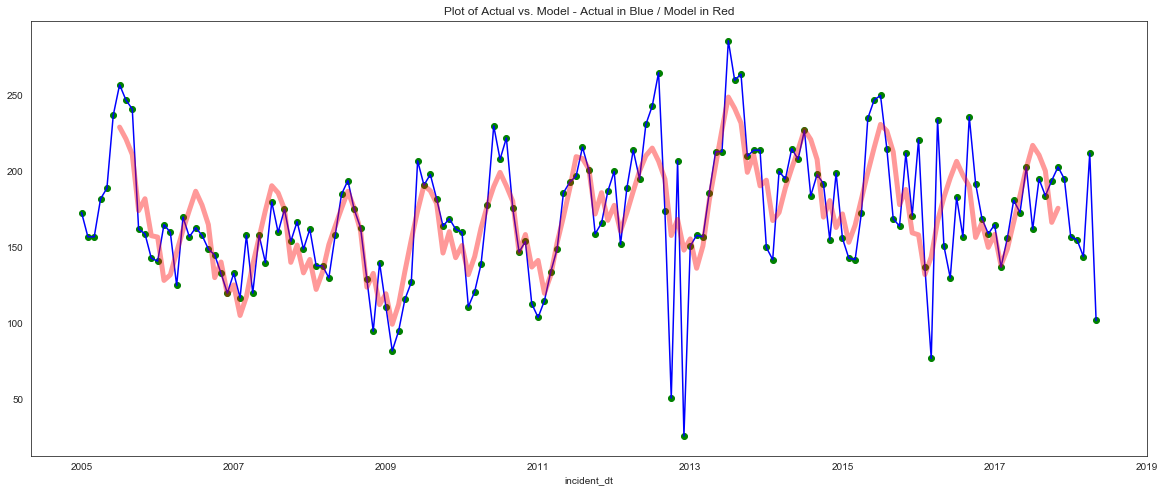

In [14]:
res['actual'].plot(style='go', sharex=True)
res['actual'].plot(color='blue', sharex=True)
#res['pred'].plot(style='ko')
res['pred'].plot(color='red', lw=5.0, sharex=True, alpha=0.4,
                 title='Plot of Actual vs. Model - Actual in Blue / Model in Red')

# Modeling the data with a time series analysis

lets build an ARMA model

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

statsmodels documentation suggests fitting an AR model to find the right lag 

In [16]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


In [17]:
# see this dicussion 
# https://github.com/statsmodels/statsmodels/issues/3247
X1 = X.astype(float)

In [18]:
# arma_mod1 = sm.tsa.ARMA(X, (14,1)).fit(disp=False)
arma = sm.tsa.ARMA(X1, (14, 1)).fit(disp=False, trend='c')

In [19]:
arima = sm.tsa.ARIMA(X1, (14, 0, 1)).fit(disp=False, trend='c')

In [20]:
print(arma.aic, arma.bic, arma.hqic)
print(arima.aic, arima.bic, arima.hqic)

1611.3347141883116 1663.7185883930474 1632.604695076611
1611.3347141883116 1663.7185883930474 1632.604695076611


arima with a 0 for i is the same as arma

In [21]:
best = arima

In [22]:
predicted = best.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.638027  -30.638027     -18.912363
2017-08-31      195  195.680307   -0.680307      -0.348875
2017-09-30      184  204.457590  -20.457590     -11.118255
2017-10-31      194  188.604453    5.395547       2.781210
2017-11-30      203  181.257058   21.742942      10.710809
2017-12-31      195  170.480534   24.519466      12.574085
2018-01-31      157  158.407748   -1.407748      -0.896655
2018-02-28      155  159.543250   -4.543250      -2.931129
2018-03-31      144  157.871564  -13.871564      -9.633030
2018-04-30      212  167.977693   44.022307      20.765239


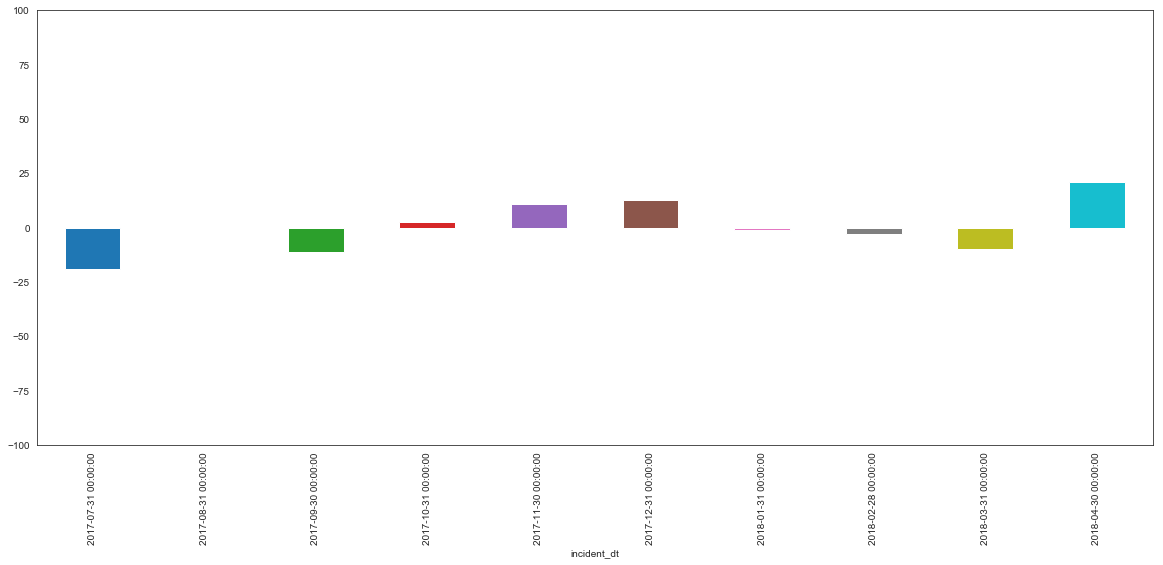

In [23]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

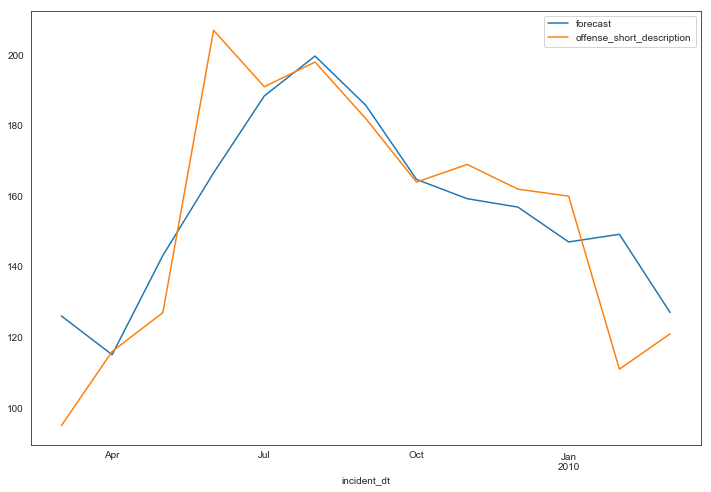

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
fig = best.plot_predict(50, 62, dynamic=False, ax=ax)

Lets do a thought experiment where we train the model on some number of months TM and use it to predict forward for some number of months PM

In [25]:
print("length of time series {}".format(len(X)))

length of time series 161


In [26]:
TM = 12*5 #train months
PM = 12 #predict months

In [27]:
train_size = TM
predict_size = PM
train, test = X[0:train_size], X[train_size:train_size + predict_size]
# using the 12 month model
predicted = best.predict(train_size, train_size + predict_size, dynamic=False)

In [28]:
compare = pd.DataFrame(test)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2010-01-31      160  147.037093   12.962907       8.101817
2010-02-28      111  149.206049  -38.206049     -34.419864
2010-03-31      121  127.047483   -6.047483      -4.997920
2010-04-30      139  137.439329    1.560671       1.122785
2010-05-31      178  151.916542   26.083458      14.653628
2010-06-30      230  191.018220   38.981780      16.948600
2010-07-31      208  214.902958   -6.902958      -3.318730
2010-08-31      222  210.987949   11.012051       4.960384
2010-09-30      176  204.621186  -28.621186     -16.262038
2010-10-31      147  176.334335  -29.334335     -19.955330
2010-11-30      154  166.012222  -12.012222      -7.800144
2010-12-31      113  145.390115  -32.390115     -28.663818


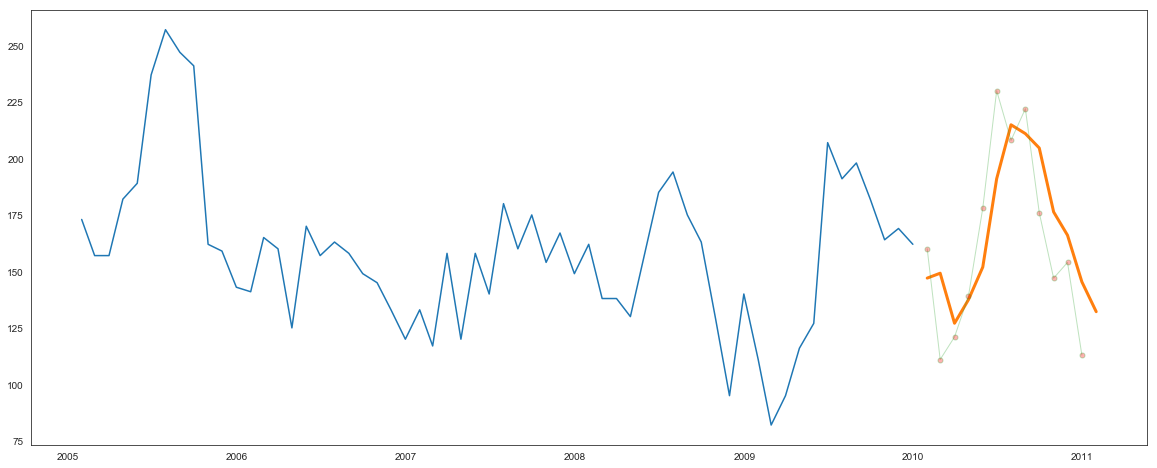

In [29]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')

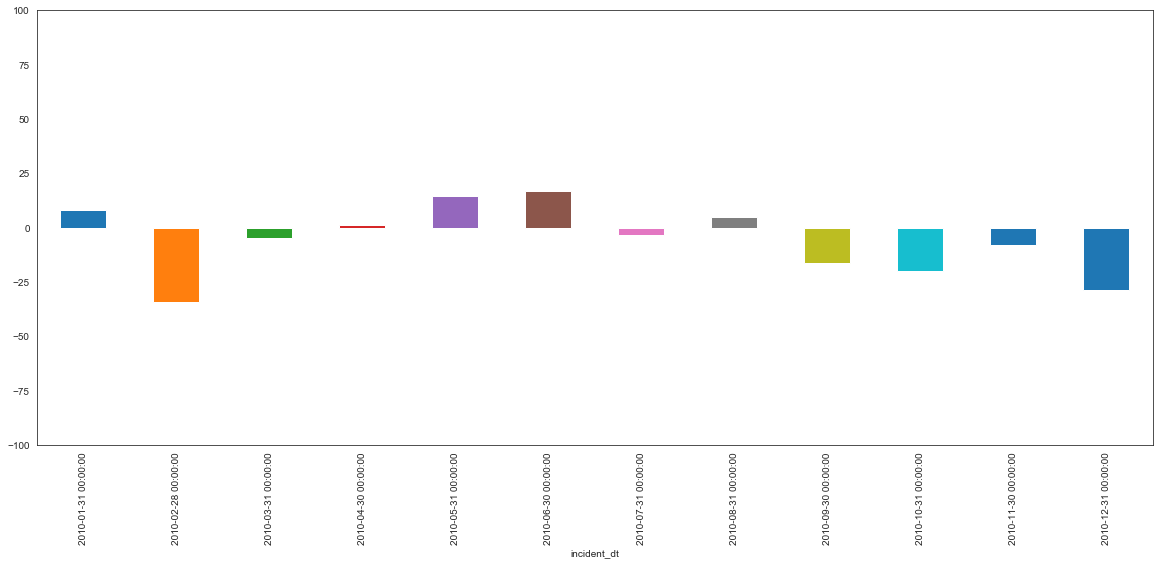

In [30]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

### things to try next

#### box-cox transform

The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data. The example below performs a log transform of the data and generates some plots to review the effect on the time series.

#### rolling forecast validation

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model. We can load this validation.csv file now and use it see how well our model really is on unseen data. There are two ways we might proceed:
􏰀 Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
􏰀 Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.
As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.